# Feature Generation 
## 1.for sampled_play
**UPDATE 3.18** sample_play_318 contains device(ip,ar, both) with adjust_play_time
### 1.1 Frequency of time_period, average play_time of the same time_period, etc 

In [27]:
import pandas as pd
import numpy as np
import datetime as dt

In [28]:
import matplotlib.pyplot as plt
% matplotlib inline

#### Load in sample_play
**[Before 3.16]**Get the sample_uid_label(8823) by merge sample_uid(8823) with sample_uid_label(8863)

In [3]:
s8823 = pd.read_csv("D:/MusicFile/sample_uid_316/sample_uid_8823.csv")
sl8862 = pd.read_csv("D:/MusicFile/sample_uid_label/sample_uid_316.csv")
sl8862.sample(8)
print(s8823.count(), sl8862.count())
sample_uid_label = s8823.merge(sl8862, on = 'uid', how = 'inner')

sample_uid_label.sample(8)

uid    8823
dtype: int64 uid      8862
churn    8862
dtype: int64


,uid,churn
177,168111040.0,0
662,167676176.0,0
1924,154560160.0,1
2320,167988528.0,0
85,168615296.0,1
1081,168696800.0,0
6535,154525376.0,1
5503,154741152.0,1


In [159]:
sample_uid_label.to_csv("D:/MusicFile/sample_uid_label8823.csv", header = True, index = False)

In [14]:
sample_uid_label=pd.read_csv("D:/MusicFile/sample_uid_label8823.csv", header = 0, index_col = 0)
sample_uid_label.sample(8)

,churn
uid,
168706400.0,0
18671898.0,1
154413408.0,1
168321472.0,0
154817520.0,1
168083408.0,0
168574048.0,0
167842240.0,0


### Load in 318 sample_play, uid_label

In [29]:
#notice the type of variables
colname = ['uid', 'song_id', 'song_length', 'date', 'Churn', 'play_time',
       'device']
datatype = {'uid': 'int64', 'Churn': 'int64'}
sample_play = pd.read_csv("D:/MusicFile/sample_play_318.csv", header = 0, dtype = datatype, names = colname)

In [39]:
sample_uid_8798 = pd.read_csv("D:/MusicFile/sample_uid_label8798.csv", header = 0, index_col = 0)
sample_uid_8798.shape

(8798, 1)

In [3]:
sample_play.sample(8)

,uid,song_id,song_length,date,Churn,play_time,device
3179182,168559712,611618.0,235.0,2017-04-21,1,235.0,ar
2136283,154778256,0.0,420.0,2017-03-04,1,420.0,ar
3769027,168850880,6802744.0,184.0,2017-04-10,0,7.0,both
3127557,154771936,5334698.0,291.0,2017-03-04,1,290.0,both
1945189,168899264,176292.0,334.0,2017-04-04,1,202.0,ar
1372132,168327168,912615.0,225.0,2017-04-03,0,93.0,both
1183540,168043664,9842191.0,708.0,2017-04-03,0,708.0,both
3200625,168162336,5262441.0,225.0,2017-04-23,1,186.0,both


In [89]:
sample_play['date'].max()

Timestamp('2017-04-28 00:00:00')

In [30]:
sample_play['date'] = pd.to_datetime(sample_play['date'])
sample_play.dtypes

uid                     int64
song_id               float64
song_length           float64
date           datetime64[ns]
Churn                   int64
play_time             float64
device                 object
dtype: object

In [5]:
#original 4955455, after cleaning 4235432
sample_play.shape

(4235432, 7)

In [6]:
#original 4465/4358, now 4464,4334
print('How many active user:',len(sample_play.uid[sample_play.Churn == 0].unique()))
print('How many churn user:',len(sample_play.uid[sample_play.Churn == 1].unique()))

How many active user: 4464
How many churn user: 4334


In [5]:

start = '2017-03-01'
end = '2017-04-29'
st,ed = pd.to_datetime(start), pd.to_datetime(end)
elapsed = ed-st

if elapsed > dt.timedelta(days = 1):
    print("Slept for > 1 day")

Slept for > 1 day


In [34]:
log_types = ['play', 'search', 'download']
window_list = [1,3,7,14,21,30]
snapshot_date = '2017-04-29'

In [31]:
def get_freq_avg(df, log_type, window, snapshot_date):
    snapshot_date = pd.to_datetime(snapshot_date)
    #df2 shows records inside window
    df2 = df.loc[(snapshot_date - df['date'])<= dt.timedelta(window), :]
    print('How many active/churn user after feature generation:',len(df2.uid[df2.Churn == 0].unique()), len(df2.uid[df2.Churn ==1].unique()))
    df_feature = df2.groupby('uid')['play_time'] \
                    .agg(['count', 'mean']) \
                    .rename(columns = {'count':'freq_' + log_type + '_last_' + str(window) + '_days',
                                       'mean' : 'avg_'+ log_type + 'time' + '_last_' + str(window) + '_days'})
    #df_feature = df_feature.rename(columns = {'date':})
    return df_feature

In [143]:
test1 = get_freq_avg(sample_play, 'play', window_list[0], snapshot_date)

How many active/churn user after feature generation: 2722 69


In [12]:
print(test1.columns, test1.shape[0])
test1.head()

Index(['freq_play_last_1_days', 'avg_playtime_last_1_days'], dtype='object') 2791


,freq_play_last_1_days,avg_playtime_last_1_days
uid,,
1901839.0,3,222.333333
2285308.0,11,107.818182
5597959.0,6,111.166667
7533076.0,4,198.000000
7910960.0,14,214.142857


In [35]:
def get_all_freq_avg(df, log_type, window_list, snapshot_time):
    type_feature = get_freq_avg(df, log_type, window_list[0], snapshot_date)
    for window in window_list[1:]:
        #what = 'freq and average time of' + log_type + '_last_' + str(window) + '_days'
        #print("Calculating", what)
        test_what = get_freq_avg(df, log_type, window, snapshot_date)
        #print(test_what.head())
        type_feature = pd.merge(test_what, type_feature, how='left', left_index=True, right_index=True)
    return type_feature

In [36]:
play_feature = get_all_freq_avg(sample_play, 'play', window_list, snapshot_date)
#since many churn user never show up,  ┓( ´∀` )┏

How many active/churn user after feature generation: 2714 65
How many active/churn user after feature generation: 3616 180
How many active/churn user after feature generation: 4080 382
How many active/churn user after feature generation: 4317 656
How many active/churn user after feature generation: 4393 880
How many active/churn user after feature generation: 4461 1402


In [37]:
print(play_feature.shape)
play_feature.sample(8)

(5863, 12)


,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,avg_playtime_last_3_days,freq_play_last_1_days,avg_playtime_last_1_days
uid,,,,,,,,,,,,
168087856,384,232.833333,143.0,215.097902,124.0,222.193548,26.0,193.461538,26.0,193.461538,NaN,NaN
167558624,14,281.428571,14.0,281.428571,14.0,281.428571,14.0,281.428571,NaN,NaN,NaN,NaN
167987504,313,157.440895,138.0,117.463768,36.0,185.583333,26.0,228.307692,23.0,229.000000,20.0,239.700000
168983872,106,219.990566,69.0,271.000000,69.0,271.000000,69.0,271.000000,69.0,271.000000,NaN,NaN
168309952,224,154.026786,119.0,155.974790,87.0,136.540230,85.0,136.623529,16.0,63.437500,11.0,65.454545
167782720,81,173.506173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166351680,10,180.700000,10.0,180.700000,10.0,180.700000,NaN,NaN,NaN,NaN,NaN,NaN
75844624,34,237.617647,3.0,175.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# add dropped churn user back
#sample_uid_8798.shape
play_feature_8798 = play_feature.join(sample_uid_8798, how = 'outer')
                                

In [41]:
print(play_feature_8798.shape)
play_feature_8798.sample(8)

(8798, 13)


,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,avg_playtime_last_3_days,freq_play_last_1_days,avg_playtime_last_1_days,Churn
uid,,,,,,,,,,,,,
167831584,2588.0,246.847759,2325.0,248.389677,1758.0,247.850398,818.0,236.882641,287.0,226.756098,169.0,210.911243,0
168791952,1894.0,139.876729,1098.0,125.788274,766.0,133.734366,271.0,146.929889,202.0,142.762376,32.0,92.656250,0
168825856,1306.0,169.735069,526.0,162.684411,174.0,158.758621,76.0,170.157895,34.0,195.147059,11.0,258.636364,0
36567948,7.0,122.142857,7.0,122.142857,7.0,122.142857,NaN,NaN,NaN,NaN,NaN,NaN,1
168039056,1111.0,179.917192,517.0,209.930368,197.0,231.365482,133.0,248.849624,132.0,249.106061,13.0,219.615385,0
168869312,360.0,151.663889,120.0,200.350000,101.0,200.049505,11.0,236.818182,NaN,NaN,NaN,NaN,0
154597840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
154293776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [17]:
print(len(sample_play.uid.unique()), play_feature.shape[0], play_feature_8823.shape[0])

8798 5273 8823


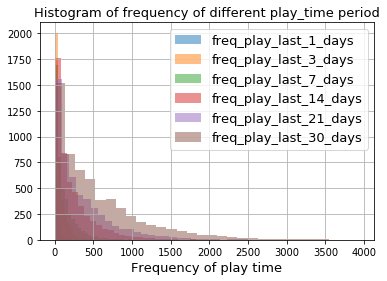

In [42]:
#plot freq_play_x_days in one figure..not clear enough, separate them

window_list = [1,3,7,14,21,30]    
fig, ax = plt.subplots()
legend_list = []
for w in window_list:
    colname = 'freq_play_last_' + str(w) + '_days'
    legend_list.append(colname)
    play_feature_8798[colname].hist(bins =30, alpha = 0.5)
    
plt.title('Histogram of frequency of different play_time period' , fontsize = 13)
plt.xlabel("Frequency of play time", fontsize = 13)
plt.legend(legend_list, loc='upper right', fontsize = 13)

In [60]:
for w in window_list:
    i = window_list.index(w)
    print(i)

0
1
2
3
4


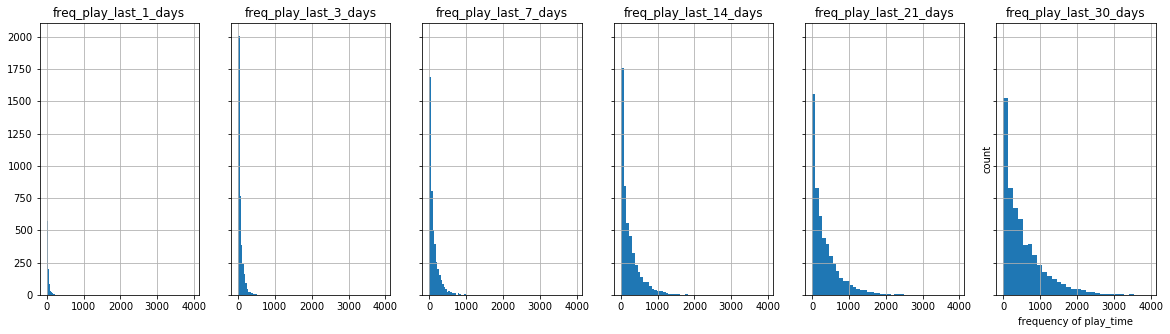

In [43]:
#plot separately
f, axs = plt.subplots(1,6, sharex = True, sharey=True, figsize = (20,5))
for w in window_list:
    i = window_list.index(w)
    colname = 'freq_play_last_' + str(w) + '_days'
    plt.xlabel("frequency of play_time")
    plt.ylabel('count')
    play_feature_8798[colname].hist(ax = axs[i], bins = 30)

    axs[i].set_title(colname)

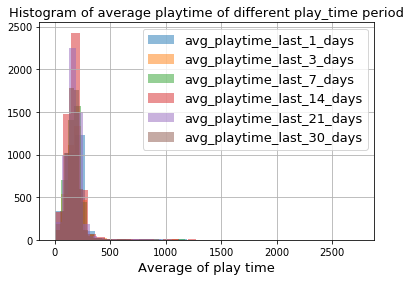

In [44]:
#plot average play time in x days
fig, ax = plt.subplots()
legend_list = []
for w in window_list:
    colname = 'avg_playtime_last_' + str(w) + '_days'
    legend_list.append(colname)
    play_feature_8798[colname].hist(bins =30, alpha = 0.5)
    
plt.title('Histogram of average playtime of different play_time period' , fontsize = 13)
plt.xlabel("Average of play time", fontsize = 13)
plt.legend(legend_list, loc='upper right', fontsize = 13)

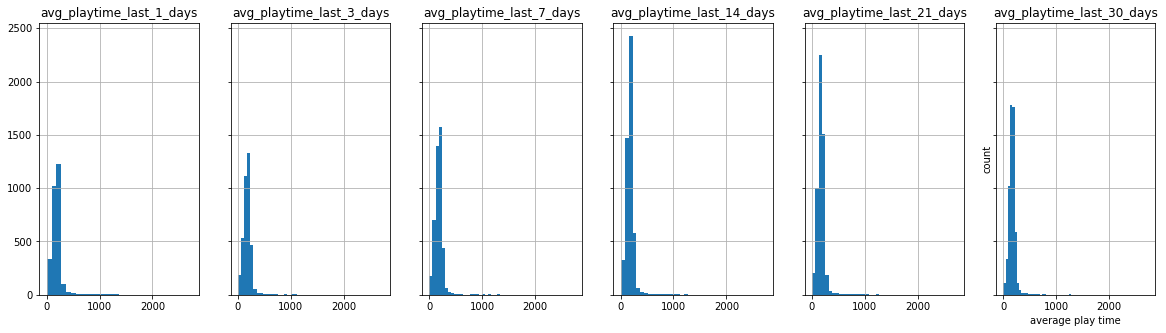

In [46]:
f, axs = plt.subplots(1,6, sharex = True, sharey=True, figsize = (20,5))
for w in window_list:
    i = window_list.index(w)
    colname = 'avg_playtime_last_' + str(w) + '_days'
    plt.xlabel("average play time")
    plt.ylabel('count')
    play_feature_8798[colname].hist(ax = axs[i], bins = 30)

    axs[i].set_title(colname)


###  1.2. device feature
## Undate by 318, so after that, no need to create device feature, can directly go search/download feature

In [18]:
sample_play[['uid', 'device', 'Churn']].drop_duplicates().shape

(12618, 3)

In [19]:
sample_play[['uid', 'Churn']].drop_duplicates().shape

(8823, 2)

Adding device as another groupby condition causing significant increase, we can assume that some users have MusicBox installed in more than one device, such as their android phone and ipad.

Create a new value for user who have both device

In [5]:
device_count = sample_play[['uid', 'device']].drop_duplicates() \
                                              .groupby('uid')['device'] \
                                              .agg(['max', 'count'])

In [100]:
device_count.head()

,max,count
uid,,
400904.0,ar,1
838955.0,ar,1
971787.0,ar,1
1264383.0,ar,1
1901839.0,ar,1


In [6]:
device_count['device'] = np.where(device_count['count'] == 1, device_count['max'], 'both')

In [7]:
device_count['device'].value_counts()

ar      4885
both    3751
ip       162
Name: device, dtype: int64

As we assumed, there are 40% user have both device

In [8]:
device_feature = sample_play[['uid', 'Churn']].drop_duplicates() \
                                               .reset_index(drop=True) \
                                               .set_index('uid') \
                                               .join(device_count['device'])

In [9]:
print(device_feature.shape)
device_feature.sample(8)

(8798, 2)


,Churn,device
uid,,
167843536,0,ar
154483216,1,ar
154606848,1,both
168612336,1,both
167972800,0,both
167881776,0,both
167936640,0,both
156894672,0,ar


In [20]:
#device_feature = device_feature.reset_index(inplace = False)
device_feature.groupby(['device', 'Churn'])['uid'].count().sum()

8798

Churn      0     1
device            
ar      2185  2700
both    2256  1495
ip        23   139


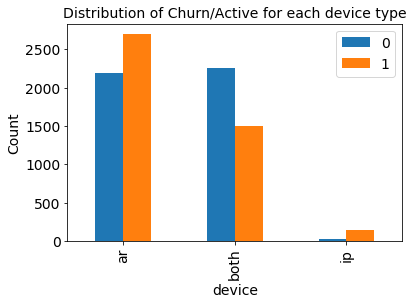

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
dc = device_feature.groupby(['device', 'Churn'])['uid'].count().unstack()
print(dc)
dcsum = dc.sum()
dc.plot(kind = 'bar', ax= ax)
plt.title('Distribution of Churn/Active for each device type' , fontsize = 14)
plt.xlabel("device", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.xticks( fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc='upper right', fontsize = 14)
#for i,v in dc.reset_index().iterrows():
#    ax.text(i,v['uid']+1, v['uid'],ha='left', va='bottom', fontsize = 12)
#    ax.text(i,(v['uid']/dcsum).round(3) + 1, (v['uid']/dcsum).round(3),ha='center',fontsize = 12)

### 1.3. merge device_feature and play_feature

In [47]:
uid_device = sample_play[['uid','device']].drop_duplicates()
uid_device.set_index('uid', inplace = True)
uid_device.shape
uid_device.sample(8)

,device
uid,
168651712,ar
154519904,both
168453408,both
125549120,ar
167621616,ar
168676064,both
155812384,ar
155769904,ar


In [48]:
play_feature_all = play_feature_8798.join(uid_device,how = "left")
print(play_feature_all.shape)
play_feature_all.sample(8)


(8798, 14)


,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,avg_playtime_last_3_days,freq_play_last_1_days,avg_playtime_last_1_days,Churn,device
uid,,,,,,,,,,,,,,
168362736,1568.0,152.141808,1071.0,157.697479,810.0,161.491358,379.0,164.002639,113.0,168.433628,68.0,197.75,0,both
167706656,461.0,158.316703,237.0,143.274262,149.0,143.798658,51.0,71.647059,26.0,59.653846,8.0,99.50,0,both
154788992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,both
154794176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,both
154657184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,both
168559184,358.0,191.466480,82.0,178.682927,9.0,135.888889,NaN,NaN,NaN,NaN,NaN,NaN,1,both
168036928,1511.0,174.262078,727.0,188.653370,438.0,189.029680,271.0,194.317343,66.0,156.515152,NaN,NaN,0,ar
154745184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,both


In [138]:
#################Original#################
print('How many active user after feature generation:',len(play_feature_all[play_feature_all.Churn == 0]))
print('How many churn user after feature generation:',len(play_feature_all[play_feature_all.Churn == 1]))

How many active user after feature generation: 4397
How many churn user after feature generation: 891


In [175]:
###################Adjusted##################
print('How many active user after feature generation:',len(play_feature_all[play_feature_all.Churn == 0]))
print('How many churn user after feature generation:',len(play_feature_all[play_feature_all.Churn == 1]))

How many active user after feature generation: 4465
How many churn user after feature generation: 4358


In [93]:
#double check the play_feature
play_feature_all.shape

(8798, 12)

### 1.4 complete_degree
check average music play complete degree of each user: avg(play_time/song_length)


In [225]:
sample_play.sample(8)

,uid,song_id,song_length,date,Churn,play_time,device
1340831,167790352,0.0,4.0,2017-04-11,0,4.0,ar
1882433,168576592,11819020.0,12.0,2017-03-30,1,12.0,both
1028167,154730000,2696023.0,208.0,2017-03-01,1,1.0,both
3959728,154775840,6227698.0,69.0,2017-03-06,1,11.0,ar
131436,168684560,6060869.0,391.0,2017-04-12,1,110.0,both
1423014,168874112,157908.0,306.0,2017-04-27,0,306.0,both
3692807,168809664,6807407.0,215.0,2017-03-30,0,5.0,ar
2330882,167854176,504089.0,91.0,2017-04-03,0,91.0,both


In [226]:
music_complete = sample_play.groupby('uid')[['play_time', 'song_length']].mean()
print('How many user play time =0:', music_complete[music_complete.play_time ==0].count())
print(music_complete.head())

How many user play time =0: play_time      0
song_length    0
dtype: int64
          play_time  song_length
uid                             
838955   181.750000   233.833333
971787    32.500000   243.000000
1264383   87.666667   234.666667
1901839  167.249548   197.471971
2163514  159.500000   248.824324


In [227]:
complete_precent = music_complete.play_time/music_complete.song_length
complete_precent = pd.DataFrame(complete_precent, columns = ['precent'])
complete_precent.reset_index(inplace = True)
complete_precent.head()
#there are 25 user with play_time =0, 928 user with play/song_length >1.

,uid,precent
0,838955,0.777263
1,971787,0.133745
2,1264383,0.373580
3,1901839,0.846953
4,2163514,0.641015


In [97]:
#check whether have out of [0,1]
complete_precent.precent[(complete_precent.precent==0)|(complete_precent.precent>1)]
#OK

Series([], Name: precent, dtype: float64)

The play_complete mean is 0.6319226954988768


Text(0,0.5,'Count')

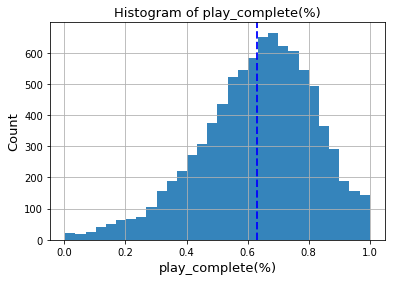

In [106]:
#plot precent
complete_precent['precent'].hist(bins =30, alpha = 0.9)
plt.title('Histogram of play_complete(%)' , fontsize = 13)
print("The play_complete mean is", complete_precent['precent'].mean())
plt.axvline(complete_precent['precent'].mean(), color='blue',alpha = 0.9, linestyle='dashed', linewidth=2)
plt.xlabel("play_complete(%)", fontsize = 13)
plt.ylabel("Count", fontsize = 13)

### 1.4. save play_feature_all

In [69]:
#this is 8823, remember to fillna with 0
play_feature_all.to_csv("D:/MusicFile/play_feature_8798_30.csv", header = True)

## 2. for search and download.log
### 2.1 frequency feature generation for search

In [94]:
sampled_search = pd.read_csv("D:/MusicFile/sample_search_316.csv")
sampled_search.sample(8)

,uid,device,file_name,date,record_time
248324,133928864.0,ar,20170430_3_search.log,2017-04-30T00:00:00.000-04:00,2017-04-30T21:05:30.000-04:00
438828,167849488.0,ar,20170330_1_search.log,2017-03-30T00:00:00.000-04:00,2017-03-30T18:31:34.000-04:00
25669,168668896.0,ar,20170417_3_search.log,2017-04-17T00:00:00.000-04:00,2017-04-17T13:49:22.000-04:00
92134,168174560.0,ar,20170412_2_search.log,2017-04-12T00:00:00.000-04:00,2017-04-12T13:27:56.000-04:00
313678,168880640.0,ar,20170330_3_search.log,2017-03-30T00:00:00.000-04:00,2017-03-30T20:01:05.000-04:00
74365,154630352.0,ar,1_4_search.log,2017-03-04T00:00:00.000-05:00,2017-03-04T14:11:18.000-05:00
115616,168307328.0,ar,20170413_2_search.log,2017-04-13T00:00:00.000-04:00,2017-04-13T15:25:52.000-04:00
135949,167642272.0,ar,20170401_1_search.log,2017-04-01T00:00:00.000-04:00,2017-04-01T17:47:05.000-04:00


In [95]:
sampled_search['date'] = pd.to_datetime(sampled_search['date'].str.slice(0,10))

In [80]:
sampled_search.sample(8)

,uid,device,file_name,date,record_time
174544,168032048.0,ar,20170405_1_search.log,2017-04-05,2017-04-05T10:43:39.000-04:00
331657,154564032.0,ar,1_1_search.log,2017-03-01,2017-03-01T16:10:14.000-05:00
93294,154794272.0,ar,1_1_search.log,2017-03-01,2017-03-01T23:29:15.000-05:00
468830,168879056.0,ar,20170330_3_search.log,2017-03-30,2017-03-30T20:14:16.000-04:00
337112,169040624.0,ar,20170419_3_search.log,2017-04-19,2017-04-19T09:31:00.000-04:00
367342,154662560.0,ar,1_1_search.log,2017-03-01,2017-03-01T19:13:47.000-05:00
99225,168376224.0,ar,20170420_2_search.log,2017-04-20,2017-04-20T18:24:33.000-04:00
213695,167907184.0,ar,20170416_1_search.log,2017-04-16,2017-04-16T23:44:42.000-04:00


In [51]:
sampled_search.dtypes

uid                   float64
device                 object
file_name              object
date           datetime64[ns]
record_time            object
dtype: object

In [52]:
sampled_search = sampled_search[['uid', 'device', 'date']]
len(sampled_search.uid.unique())

7714

In [85]:
sampled_search.to_csv("D:/MusicFile/sampled_search_316new.csv", header = True)

In [ ]:
'''
def get_freq_avg(df, log_type, window, snapshot_date):
    snapshot_date = pd.to_datetime(snapshot_date)
    df2 = df.loc[(snapshot_date - df['date'])<= dt.timedelta(window), :]
    df_feature = df2.groupby('uid')['play_time'] \
    .agg(['count', 'mean']) \
    .rename(columns = {'count':'freq_' + log_type + '_last_' + str(window) + '_days',
                       'mean' : 'avg_'+ log_type + 'time' + '_last_' + str(window) + '_days'})
    return df_feature

def get_all_freq(df, log_type, window_list, snapshot_time):
    type_feature = get_freq_avg(df, log_type, window_list[0], snapshot_date)
    for window in window_list[1:]:
        test_what = get_freq_avg(df, log_type, window, snapshot_date
        type_feature = pd.merge(test_what, type_feature, how='left', left_index=True, right_index=True)
    return type_feature


log_types = ['play', 'search', 'download']
window_list = [1,3,7,14,21]
snapshot_date = '2017-04-29'

'''


In [86]:
log_types = ['play', 'search', 'download']
window_list = [1,3,7,14,21,30]
snapshot_date = '2017-04-29'

In [53]:
def get_freq(df, log_type, window, snapshot_time):
    snapshot_date = pd.to_datetime(snapshot_time)
    df2 = df.loc[(snapshot_date - df['date'])<= dt.timedelta(window), :]
    df_feature = df2.groupby('uid')['date'] \
                    .agg(['count']) \
                    .rename(columns = {'count':'freq_' + log_type + '_last_' + str(window) + '_days'})
    
    return df_feature

In [9]:
sest = get_freq(sampled_search, 'search', window_list[0], snapshot_date)
sest.head()

,freq_search_last_1_days
uid,
1901839.0,5
2163514.0,1
2285308.0,1
3752046.0,3
5597959.0,18


In [54]:
def get_all_freq(df, log_type, window_list, snapshot_time):
    type_feature = get_freq(df, log_type, window_list[0], snapshot_date)
    for window in window_list[1:]:
        test_what = get_freq(df, log_type, window, snapshot_date)
        type_feature = pd.merge(test_what, type_feature, how='left', left_index=True, right_index=True)
    return type_feature

In [55]:
search_feature = get_all_freq(sampled_search, 'search', window_list, snapshot_date)

In [56]:
search_feature.sample(8)
#notice: uid now is the row index, we need it as a column uid, but when save to csv, it automatically change to a column

,freq_search_last_30_days,freq_search_last_21_days,freq_search_last_14_days,freq_search_last_7_days,freq_search_last_3_days,freq_search_last_1_days
uid,,,,,,
151486256.0,3,3.0,1.0,1.0,1.0,1.0
168048112.0,11,10.0,10.0,10.0,10.0,1.0
168489712.0,110,18.0,13.0,11.0,8.0,8.0
139851616.0,114,35.0,1.0,NaN,NaN,NaN
168577888.0,3,NaN,NaN,NaN,NaN,NaN
168985984.0,33,12.0,12.0,7.0,5.0,4.0
168757824.0,312,179.0,164.0,126.0,117.0,115.0
168319296.0,79,64.0,56.0,42.0,41.0,34.0


In [57]:
#same as  play_feature, there are some churn user never show up during the window time
search_feature.shape

(5211, 6)

In [58]:
search_feature.to_csv("D:/MusicFile/search_feature_318.csv", header = True)

### 2.2 frequency feature generation for download

In [96]:
sampled_download = pd.read_csv("D:/MusicFile/sample_download_316.csv")
sampled_download['date'] = pd.to_datetime(sampled_download['date'].str.slice(0,10))
sampled_download.sample(8)

,uid,device,song_id,date
193736,168877040.0,ar,23532356.0,2017-04-06
84347,168703680.0,ar,5185874.0,2017-05-10
9652,168287040.0,ar,708287.0,2017-04-02
166277,169038144.0,ip,19087234.0,2017-03-30
76435,39560840.0,ar,6585112.0,2017-04-03
277633,167906032.0,ar,6657692.0,2017-04-15
162043,168574288.0,ar,13800660.0,2017-03-30
247365,168490624.0,ar,176292.0,2017-04-03


In [16]:
dest = get_freq(sampled_download, 'download', window_list[0], snapshot_date)
dest.head()

,freq_download_last_1_days
uid,
2280694.0,5
3752046.0,1
7910960.0,3
8853855.0,2
14780539.0,27


In [60]:
download_feature = get_all_freq(sampled_download, 'download', window_list, snapshot_date)

In [61]:
download_feature.sample(8)

,freq_download_last_30_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days
uid,,,,,,
167905248.0,13,7.0,1.0,NaN,NaN,NaN
168302176.0,55,40.0,36.0,5.0,4.0,4.0
169027984.0,527,286.0,165.0,74.0,64.0,60.0
168110000.0,4,2.0,1.0,1.0,1.0,1.0
140533488.0,1,NaN,NaN,NaN,NaN,NaN
168434896.0,15,13.0,1.0,NaN,NaN,NaN
151637920.0,1,1.0,1.0,1.0,1.0,1.0
168509952.0,12,12.0,12.0,12.0,12.0,12.0


In [62]:
download_feature.shape

(4738, 6)

In [63]:
download_feature.to_csv("D:/MusicFile/download_feature_318.csv", header = True)

In [38]:
#join search and download
ds = pd.merge(search_feature, download_feature, left_on = 'uid', right_on = 'uid',  how = 'left')
ds.sample(10)

,uid,freq_search_last_21_days,freq_search_last_14_days,freq_search_last_7_days,freq_search_last_3_days,freq_search_last_1_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days
3628,168710656.0,3,NaN,NaN,NaN,NaN,6.0,2.0,NaN,NaN,NaN
3654,168719200.0,17,14.0,10.0,8.0,8.0,11.0,8.0,4.0,3.0,3.0
130,125439600.0,2,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4513,169007776.0,58,48.0,40.0,39.0,35.0,162.0,153.0,152.0,10.0,9.0
3093,168515184.0,35,10.0,8.0,6.0,6.0,4.0,NaN,NaN,NaN,NaN
2288,168248544.0,8,5.0,5.0,5.0,5.0,31.0,2.0,2.0,2.0,2.0
3017,168489712.0,18,13.0,11.0,8.0,8.0,4.0,3.0,3.0,3.0,3.0
2735,168397136.0,15,1.0,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN
3874,168789456.0,14,12.0,7.0,1.0,1.0,7.0,5.0,5.0,1.0,NaN
1960,168130448.0,90,65.0,37.0,28.0,28.0,43.0,9.0,8.0,8.0,8.0


### 2.5 Recency
what is the last show up day of one user in three log.type?

In [146]:
snapshot_date = pd.to_datetime('2017-04-29')
snapshot_date = pd.to_datetime(snapshot_date)

In [147]:
def compute_recency(df, types, snapshot_date):
    
    last = df.groupby('uid')['date'].agg(['max'])
    last['last_' + types] = (snapshot_date - last['max']).apply(lambda x: x.days)
 
    last.drop(columns=['max'], inplace=True)
    return last

In [159]:
#filter search/download

sampled_search = sampled_search[sampled_search['date'] <snapshot_date]
sampled_download = sampled_download[sampled_download['date'] <snapshot_date]
sampled_search['date'].max()
sampled_download['date'].max()

Timestamp('2017-04-28 00:00:00')

In [160]:
recency_play = compute_recency(sample_play, 'play', snapshot_date)
recency_search = compute_recency(sampled_search, 'search', snapshot_date)
recency_download = compute_recency(sampled_download, 'download', snapshot_date)

recency <0 means user have some active after 4.29, because we only filter by play not search/download

In [162]:
recency_search[recency_search.last_search.isnull()]
recency_download[recency_download.last_download.isnull()]

,last_download
uid,


In [150]:
recency_search.head()

,last_search
uid,
838955.0,15
2285308.0,1
2380836.0,30
3068886.0,27
3414451.0,3


In [163]:
recency_play = recency_play.reset_index(inplace = False)
recency_search= recency_search.reset_index(inplace = False)
recency_download=recency_download.reset_index(inplace = False)

### 3.Join play, search, download feature
Since our analysis based on play, so if user doesn't have search, download, just plugged in NaN
play_feature_all has 8798 user, search has 5211, download has 4738

In [66]:
print(5211/8798, 4738/8798)

0.5922937031143441 0.5385314844282791


In [186]:
#reload type_feature

play_feature_all = pd.read_csv("D:/MusicFile/play_feature_8798_30.csv")
search_feature = pd.read_csv("D:/MusicFile/search_feature_318.csv")
download_feature = pd.read_csv("D:/MusicFile/download_feature_318.csv")

In [187]:
print("play_feature:",play_feature_all.shape)
print("search_feature:",search_feature.shape)
print("download_feature:",download_feature.shape)

play_feature: (8798, 15)
search_feature: (5211, 7)
download_feature: (4738, 7)


In [131]:
recency_play.head()

,uid,last_play
0,838955,13
1,971787,31
2,1264383,30
3,1901839,1
4,2163514,2


In [188]:
all_feature = play_feature_all.merge(search_feature, on = 'uid', how = "left") \
                              .merge(download_feature, on = 'uid', how = 'left') \
                              .merge(recency_play, on = 'uid', how = 'left') \
                            .merge(recency_search, on = 'uid', how = 'left') \
            .merge(recency_download, on = 'uid', how = 'left') \
    

In [189]:
all_feature.sample(10)    

,uid,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,...,freq_search_last_1_days,freq_download_last_30_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days,last_play,last_search,last_download
4074,167625392,25.0,34.680000,19.0,15.052632,19.0,15.052632,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,9,9.0,NaN
3258,155375696,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,57.0,NaN
250,73131504,399.0,85.766917,397.0,85.675063,397.0,85.675063,397.0,85.675063,NaN,...,NaN,121.0,121.0,121.0,121.0,NaN,NaN,5,5.0,5.0
8095,168839968,659.0,151.295903,284.0,181.566901,170.0,187.847059,109.0,177.559633,61.0,...,17.0,125.0,14.0,8.0,8.0,5.0,5.0,1,13.0,1.0
6390,168333040,193.0,206.968912,151.0,225.403974,81.0,291.308642,59.0,316.593220,40.0,...,187.0,287.0,286.0,286.0,286.0,253.0,253.0,3,3.0,6.0
8187,168872304,553.0,114.088608,267.0,125.816479,152.0,137.335526,71.0,139.154930,11.0,...,10.0,358.0,8.0,2.0,1.0,NaN,NaN,1,4.0,4.0
3406,157764832,5.0,123.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,29.0,NaN
185,52033136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59,59.0,NaN
1326,154477856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,56.0,NaN
699,152176320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51,56.0,NaN


In [190]:
all_feature.shape

(8798, 30)

In [203]:
all_feature_in = all_feature.drop('Churn',axis = 1).drop('device', axis = 1).drop('last_play', axis = 1)
cdp = all_feature[['uid','Churn', 'device', 'last_play']]
all_feature_in = all_feature_in.set_index('uid')
#all_feature_in.isnull().sum()


In [204]:
cdp.head()

,uid,Churn,device,last_play
0,838955,1,ar,13
1,971787,1,ar,31
2,1264383,1,ar,30
3,1901839,0,ar,1
4,2163514,0,ar,2


In [205]:
all_feature_in.head()

,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,avg_playtime_last_3_days,...,freq_search_last_3_days,freq_search_last_1_days,freq_download_last_30_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days,last_search,last_download
uid,,,,,,,,,,,,,,,,,,,,,
838955,12.0,181.750000,5.0,209.400000,2.0,210.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,15.0,25.0
971787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1264383,3.0,87.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1901839,521.0,163.731286,422.0,151.727488,309.0,147.407767,167.0,129.688623,56.0,128.357143,...,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,1.0,16.0
2163514,74.0,159.500000,74.0,159.500000,74.0,159.500000,20.0,127.300000,19.0,124.105263,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN


In [206]:
all_feature_in[all_feature_in.isnull().all(axis=1)].shape
#nan = df[df.isnull().all(axis=1)].index

(432, 26)

In [207]:
#if all feature is NaN, drop those user
all_feature_in = all_feature_in.dropna(axis = 0, how = 'all')

In [208]:
#then fill na with 0/90
all_feature_fill0 = all_feature_in.drop('last_search',axis = 1).drop('last_download', axis = 1)
all_feature_fill0 = all_feature_fill0.fillna(0)
all_feature_fill0.sample(8)

,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,avg_playtime_last_3_days,...,freq_search_last_14_days,freq_search_last_7_days,freq_search_last_3_days,freq_search_last_1_days,freq_download_last_30_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days
uid,,,,,,,,,,,,,,,,,,,,,
168777776,22.0,115.545455,16.0,92.562500,9.0,27.555556,9.0,27.555556,9.0,27.555556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154535568,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168335152,136.0,77.250000,43.0,78.418605,42.0,77.000000,21.0,77.761905,21.0,77.761905,...,64.0,62.0,62.0,62.0,35.0,24.0,23.0,20.0,20.0,20.0
168437616,145.0,133.089655,37.0,95.864865,22.0,114.772727,6.0,77.666667,1.0,243.000000,...,18.0,5.0,3.0,3.0,11.0,9.0,4.0,2.0,0.0,0.0
154338752,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
168948336,883.0,170.419026,489.0,180.586912,364.0,189.793956,150.0,238.420000,62.0,245.338710,...,45.0,29.0,25.0,25.0,59.0,34.0,25.0,22.0,20.0,20.0
168169760,840.0,227.546429,412.0,218.667476,363.0,209.944904,237.0,232.143460,77.0,215.675325,...,16.0,13.0,13.0,12.0,1.0,1.0,1.0,1.0,1.0,1.0
167947616,5.0,183.600000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0


In [211]:
recency_feature = all_feature_in[['last_search', 'last_download']]
recency_feature= recency_feature.reset_index(inplace= False)
#all_feature_fill0 = all_feature_fill0.reset_index(inplace = False)

In [210]:
#cdp = cdp.reset_index(inplace = False)
cdp.head()

,uid,Churn,device,last_play
0,838955,1,ar,13
1,971787,1,ar,31
2,1264383,1,ar,30
3,1901839,0,ar,1
4,2163514,0,ar,2


In [212]:
all_feature_new = all_feature_fill0.merge(recency_feature, on = 'uid', how = 'left').fillna(90)

In [214]:
all_feature_new.head()

,uid,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,...,freq_search_last_3_days,freq_search_last_1_days,freq_download_last_30_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days,last_search,last_download
0,838955,12.0,181.750000,5.0,209.400000,2.0,210.500000,0.0,0.000000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15.0,25.0
1,1264383,3.0,87.666667,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,90.0
2,1901839,521.0,163.731286,422.0,151.727488,309.0,147.407767,167.0,129.688623,56.0,...,5.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,16.0
3,2163514,74.0,159.500000,74.0,159.500000,74.0,159.500000,20.0,127.300000,19.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,90.0
4,2280694,12.0,140.333333,9.0,130.888889,7.0,95.000000,0.0,0.000000,0.0,...,0.0,0.0,14.0,14.0,8.0,5.0,5.0,5.0,90.0,11.0


In [215]:
all_feature_all = all_feature_new.merge(cdp, on = 'uid', how = 'inner')
all_feature_all.shape

(8366, 30)

In [216]:
all_feature_all.columns

Index(['uid', 'freq_play_last_30_days', 'avg_playtime_last_30_days',
       'freq_play_last_21_days', 'avg_playtime_last_21_days',
       'freq_play_last_14_days', 'avg_playtime_last_14_days',
       'freq_play_last_7_days', 'avg_playtime_last_7_days',
       'freq_play_last_3_days', 'avg_playtime_last_3_days',
       'freq_play_last_1_days', 'avg_playtime_last_1_days',
       'freq_search_last_30_days', 'freq_search_last_21_days',
       'freq_search_last_14_days', 'freq_search_last_7_days',
       'freq_search_last_3_days', 'freq_search_last_1_days',
       'freq_download_last_30_days', 'freq_download_last_21_days',
       'freq_download_last_14_days', 'freq_download_last_7_days',
       'freq_download_last_3_days', 'freq_download_last_1_days', 'last_search',
       'last_download', 'Churn', 'device', 'last_play'],
      dtype='object')

## One_hot_encoding for device
sklearn can not accept numeric variables, for device, either use one-hot encoding or try model without device, save both and try later.

In [217]:
all_feature_all.sample(8)

,uid,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,...,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days,last_search,last_download,Churn,device,last_play
3702,167640976,1238.0,148.054927,643.0,151.251944,444.0,176.202703,247.0,197.360324,34.0,...,31.0,20.0,6.0,3.0,2.0,4.0,2.0,0,both,1
1737,154613984,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,56.0,90.0,1,ar,55
3612,167618032,12.0,238.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,90.0,1,ar,25
4505,167881696,73.0,76.479452,40.0,71.025000,0.0,0.000000,0.0,0.000000,0.0,...,10.0,0.0,0.0,0.0,0.0,20.0,20.0,0,ar,20
205,71860104,23.0,162.608696,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,90.0,90.0,1,ar,30
3376,167457504,1.0,295.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,28.0,90.0,1,ar,28
4477,167871984,49.0,169.591837,43.0,168.209302,34.0,199.470588,1.0,205.000000,0.0,...,4.0,1.0,0.0,0.0,0.0,5.0,11.0,1,both,5
769,154426560,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,56.0,90.0,1,both,51


In [218]:
device_dummies = pd.get_dummies(all_feature_all.device)

In [219]:
device_dummies.sample(10)

,ar,both,ip
125,1,0,0
2968,1,0,0
1464,1,0,0
1552,0,1,0
7671,0,1,0
3604,1,0,0
2507,0,1,0
143,1,0,0
4823,0,1,0
1579,1,0,0


In [221]:
#merge to the all_feature as all_feature_device_dummy
all_feature_all['device_ar'], all_feature_all['device_both'], all_feature_all['device_ip'] = device_dummies.ar, device_dummies.both, device_dummies.ip
all_feature_dd = all_feature_all.drop('device', 1)


In [222]:
all_feature_dd.sample(5)

,uid,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,...,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days,last_search,last_download,Churn,last_play,device_ar,device_both,device_ip
7244,168719872,140.0,122.014286,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,30.0,25.0,0,27,1,0,0
3670,167632128,305.0,228.816393,176.0,225.545455,37.0,260.621622,0.0,0.000000,0.0,...,0.0,0.0,0.0,6.0,90.0,0,13,1,0,0
6301,168437072,152.0,212.585526,91.0,239.054945,53.0,256.962264,15.0,286.733333,0.0,...,0.0,0.0,0.0,90.0,28.0,0,4,1,0,0
2941,155769904,6.0,239.000000,5.0,116.600000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,90.0,20.0,1,20,1,0,0
6265,168427088,97.0,111.329897,13.0,93.076923,12.0,83.666667,3.0,33.333333,0.0,...,1.0,0.0,0.0,14.0,6.0,0,6,0,1,0


In [223]:
#drop device as all_feature_no_d
all_feature_nd = all_feature_dd.drop(['device_ar', 'device_ip', 'device_both'],1)
all_feature_nd.sample(5)

,uid,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,...,freq_download_last_30_days,freq_download_last_21_days,freq_download_last_14_days,freq_download_last_7_days,freq_download_last_3_days,freq_download_last_1_days,last_search,last_download,Churn,last_play
5204,168094304,1444.0,188.889197,854.0,203.939110,447.0,204.825503,102.0,212.294118,53.0,...,36.0,18.0,14.0,10.0,8.0,7.0,7.0,2.0,0,1
3771,167659632,1462.0,214.954172,979.0,232.043922,578.0,224.261246,196.0,219.867347,71.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1
5383,168149152,209.0,219.779904,158.0,234.613924,103.0,231.679612,75.0,227.666667,44.0,...,56.0,37.0,10.0,10.0,7.0,7.0,6.0,6.0,0,1
5502,168184080,677.0,133.642541,506.0,123.756917,295.0,136.847458,119.0,151.806723,64.0,...,167.0,154.0,46.0,21.0,17.0,11.0,3.0,2.0,0,1
5423,168160896,367.0,249.220708,262.0,258.954198,107.0,265.336449,63.0,230.523810,14.0,...,2.0,1.0,1.0,1.0,0.0,0.0,6.0,6.0,0,1


# different version of features

In [228]:
#add precentage
all_feature_total = all_feature_dd.merge(complete_precent, on = 'uid', how = 'inner')
print(len(all_feature_total.uid.unique()))
all_feature_total.sample(8)

8366


,uid,freq_play_last_30_days,avg_playtime_last_30_days,freq_play_last_21_days,avg_playtime_last_21_days,freq_play_last_14_days,avg_playtime_last_14_days,freq_play_last_7_days,avg_playtime_last_7_days,freq_play_last_3_days,...,freq_download_last_3_days,freq_download_last_1_days,last_search,last_download,Churn,last_play,device_ar,device_both,device_ip,precent
6290,168434864,242.0,136.239669,185.0,111.756757,106.0,117.396226,2.0,172.500000,0.0,...,0.0,0.0,11.0,16.0,1,7,0,0,1,0.589708
3985,167721888,1243.0,210.911504,737.0,205.166893,567.0,202.523810,465.0,228.395699,176.0,...,1.0,1.0,4.0,4.0,0,2,1,0,0,0.896268
5530,168193280,761.0,163.947438,342.0,204.043860,201.0,197.646766,88.0,194.943182,6.0,...,0.0,0.0,6.0,8.0,0,1,0,1,0,0.739399
6007,168350176,1116.0,161.800179,833.0,166.774310,578.0,177.406574,245.0,191.620408,61.0,...,9.0,9.0,1.0,1.0,0,1,0,1,0,0.686867
2819,154834224,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,56.0,90.0,1,51,1,0,0,0.821584
5671,168239504,87.0,191.206897,60.0,198.850000,34.0,187.647059,18.0,186.944444,11.0,...,3.0,3.0,5.0,14.0,0,1,0,1,0,0.635749
8065,168966752,715.0,157.594406,366.0,180.237705,230.0,167.552174,171.0,153.713450,127.0,...,3.0,3.0,1.0,7.0,0,1,0,1,0,0.624820
5937,168328640,801.0,90.506866,310.0,134.645161,272.0,135.551471,107.0,126.532710,31.0,...,9.0,9.0,1.0,1.0,0,1,1,0,0,0.400042


In [229]:
all_feature_dd.to_csv("D:/MusicFile/all_feature_dd_8366.csv", header = True, index = False)

In [230]:
all_feature_nd.to_csv("D:/MusicFile/all_feature_nd_8366.csv", header = True, index = False)

In [231]:
all_feature_total.to_csv("D:/MusicFile/all_feature_total_8366.csv", header = True, index = False)

## END